## Preprocessing

### Read

In [1]:
import pandas as pd
import re
import spacy

import torch
from torch_geometric.data import HeteroData

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [2]:
filename = 'data/arxiv-metadata-oai-snapshot-10000.csv'
df = pd.read_csv(filename)

In [3]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,NaN,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[['Balázs', 'C.', ''], ['Berger', 'E. L.', '']..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,NaN,NaN,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[['Streinu', 'Ileana', ''], ['Theran', 'Louis'..."
2,704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",NaN,NaN,NaN,physics.gen-ph,NaN,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[['Pan', 'Hongjun', '']]"
3,704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,NaN,NaN,NaN,math.CO,NaN,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[['Callan', 'David', '']]"
4,704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,NaN,"Illinois J. Math. 52 (2008) no.2, 681-689",NaN,NaN,math.CA math.FA,NaN,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[['Abu-Shammala', 'Wael', ''], ['Torchinsky', ..."


### Transform columns

In [4]:
# extract number of pages from string: e.g. "37 pages, 15 figures; published version"

def extract_pages(s):
    match = re.search(r"(\d+)\s*pages", s)
    if match:
        return int(match.group(1))
    else:
        return None

In [5]:
# format columns to right format and extract information
# Quelle warum genau die neuen Spalten fürPaper suchen

df['authors_parsed'] = df['authors_parsed'].apply(lambda x: [" ".join(i).strip() for i in eval(x)]) # authors to name, first name and list
df['versions'] = df['versions'].apply(lambda x: eval(x)[0]["created"]) # first version / created
df['timestamp'] = pd.to_datetime(df['versions'], format="%a, %d %b %Y %H:%M:%S %Z") # 
df['timestamp'] = df['timestamp'].apply(lambda x: x.timestamp())
df["categories"] = df["categories"].apply(lambda x: x.split(" ")) # sdeperate categories by comma
df.drop(columns=["submitter", "versions", "update_date", "authors"], inplace=True)
df["pages"] = df.comments.apply(lambda x: extract_pages(str(x))) # extract page number
df.head()

,id,title,comments,journal-ref,doi,report-no,categories,license,abstract,authors_parsed,timestamp,pages
0,704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,[hep-ph],NaN,A fully differential calculation in perturba...,"[Balázs C., Berger E. L., Nadolsky P. M., Yuan...",1.175542e+09,37.0
1,704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,NaN,NaN,"[math.CO, cs.CG]",http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[Streinu Ileana, Theran Louis]",1.175308e+09,NaN
2,704.0003,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",NaN,NaN,NaN,[physics.gen-ph],NaN,The evolution of Earth-Moon system is descri...,[Pan Hongjun],1.175460e+09,23.0
3,704.0004,A determinant of Stirling cycle numbers counts...,11 pages,NaN,NaN,NaN,[math.CO],NaN,We show that a determinant of Stirling cycle...,[Callan David],1.175311e+09,11.0
4,704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,NaN,"Illinois J. Math. 52 (2008) no.2, 681-689",NaN,NaN,"[math.CA, math.FA]",NaN,In this paper we show how to compute the $\L...,"[Abu-Shammala Wael, Torchinsky Alberto]",1.175537e+09,NaN


### Define size of dataset

In [6]:
df_short = df[:3]

### Lemmatization

In [7]:
nlp = spacy.load("en_core_web_sm")

def lemm(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

In [8]:
# create lists that contain lemmatized words from abstracts, titles, and lists of authors and categories for each entry in the DataFrame


all_words, all_authors, all_categories, all_title_words = [], [], [], []

for index, row in df_short.iterrows():
    text = row['abstract']
    title = row['title']
    author = row['authors_parsed']
    category = row['categories'] 
    # tokenized_words = tokenize_and_normalize(text)
    lemm_words = lemm(text)
    lemm_title_words = lemm(title)
    # tokenized_words_list.append(tokenized_words)
    all_words.append(lemm_words)
    all_authors.append(author)
    all_categories.append(category)
    all_title_words.append(lemm_title_words)



print(all_words)
print(all_authors)
print(all_categories)
print(all_title_words)

[['a', 'fully', 'differential', 'calculation', 'in', 'perturbative', 'quantum', 'chromodynamic', 'be', 'present', 'for', 'the', 'production', 'of', 'massive', 'photon', 'pair', 'at', 'hadron', 'collider', 'all', 'next', 'to', 'lead', 'order', 'perturbative', 'contribution', 'from', 'quark', 'antiquark', 'gluon-(anti)quark', 'and', 'gluon', 'gluon', 'subprocesse', 'be', 'include', 'as', 'well', 'as', 'all', 'order', 'resummation', 'of', 'initial', 'state', 'gluon', 'radiation', 'valid', 'at', 'next', 'to', 'next', 'to', 'lead', 'logarithmic', 'accuracy', 'the', 'region', 'of', 'phase', 'space', 'be', 'specify', 'in', 'which', 'the', 'calculation', 'be', 'most', 'reliable', 'good', 'agreement', 'be', 'demonstrate', 'with', 'datum', 'from', 'the', 'Fermilab', 'Tevatron', 'and', 'prediction', 'be', 'make', 'for', 'more', 'detailed', 'test', 'with', 'CDF', 'and', 'do', 'datum', 'prediction', 'be', 'show', 'for', 'distribution', 'of', 'diphoton', 'pair', 'produce', 'at', 'the', 'energy', 'of

### Delete Stopwords

In [9]:
# !pip3 install nltk

In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Laden der Stoppwörter
stop_words = set(stopwords.words('english'))

# Entfernen der Stoppwörter aus jedem Dokument
filtered_all_words = []
for words in all_words:
    filtered_words = [word for word in words if word not in stop_words]
    filtered_all_words.append(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ilgar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [12]:
filtered_all_words

[['fully',
  'differential',
  'calculation',
  'perturbative',
  'quantum',
  'chromodynamic',
  'present',
  'production',
  'massive',
  'photon',
  'pair',
  'hadron',
  'collider',
  'next',
  'lead',
  'order',
  'perturbative',
  'contribution',
  'quark',
  'antiquark',
  'gluon-(anti)quark',
  'gluon',
  'gluon',
  'subprocesse',
  'include',
  'well',
  'order',
  'resummation',
  'initial',
  'state',
  'gluon',
  'radiation',
  'valid',
  'next',
  'next',
  'lead',
  'logarithmic',
  'accuracy',
  'region',
  'phase',
  'space',
  'specify',
  'calculation',
  'reliable',
  'good',
  'agreement',
  'demonstrate',
  'datum',
  'Fermilab',
  'Tevatron',
  'prediction',
  'make',
  'detailed',
  'test',
  'CDF',
  'datum',
  'prediction',
  'show',
  'distribution',
  'diphoton',
  'pair',
  'produce',
  'energy',
  'Large',
  'Hadron',
  'Collider',
  'LHC',
  'distribution',
  'diphoton',
  'pair',
  'decay',
  'Higgs',
  'boson',
  'contrast',
  'produce',
  'QCD',
  'proc

### List with every word

In [13]:
# create lists with every value without double lists

words_values = [word for sublist in filtered_all_words for word in sublist]

print(words_values)

authors_values = [author for sublist in all_authors for author in sublist]

categories_values = [category for sublist in all_categories for category in sublist]

title_values = [title for sublist in all_title_words for title in sublist]

['fully', 'differential', 'calculation', 'perturbative', 'quantum', 'chromodynamic', 'present', 'production', 'massive', 'photon', 'pair', 'hadron', 'collider', 'next', 'lead', 'order', 'perturbative', 'contribution', 'quark', 'antiquark', 'gluon-(anti)quark', 'gluon', 'gluon', 'subprocesse', 'include', 'well', 'order', 'resummation', 'initial', 'state', 'gluon', 'radiation', 'valid', 'next', 'next', 'lead', 'logarithmic', 'accuracy', 'region', 'phase', 'space', 'specify', 'calculation', 'reliable', 'good', 'agreement', 'demonstrate', 'datum', 'Fermilab', 'Tevatron', 'prediction', 'make', 'detailed', 'test', 'CDF', 'datum', 'prediction', 'show', 'distribution', 'diphoton', 'pair', 'produce', 'energy', 'Large', 'Hadron', 'Collider', 'LHC', 'distribution', 'diphoton', 'pair', 'decay', 'Higgs', 'boson', 'contrast', 'produce', 'QCD', 'process', 'LHC', 'show', 'enhance', 'sensitivity', 'signal', 'obtain', 'judicious', 'selection', 'event', 'describe', 'new', 'algorithm', '$', 'k,\\ell)$-peb

### Delete duplicates

In [14]:
list(set(words_values))

['sparsity',
 'model',
 'behavior',
 'judicious',
 'agreement',
 'year',
 'far',
 'order',
 'generalize',
 'decay',
 'derive',
 'family',
 'ago',
 'may',
 'include',
 'recent',
 'event',
 'arboricity',
 '4.5',
 'radiation',
 'produce',
 'describe',
 'result',
 'Higgs',
 'system',
 'Division',
 'pair',
 'evidence',
 'predict',
 'rigidity',
 'sensitivity',
 'color',
 'Tevatron',
 'Lee',
 'close',
 's^(-2',
 'test',
 'tree',
 'graph',
 'contribution',
 'American',
 'Nash',
 'slow',
 'specify',
 'algorithmic',
 'cause',
 'rotation',
 'Mars',
 'constant',
 'phase',
 'problem',
 'subprocesse',
 'distribution',
 'receive',
 'suggest',
 'energy',
 'km',
 'contrast',
 'k,\\ell)$-sparse',
 'expose',
 'logarithmic',
 'chromodynamic',
 'Field',
 'obtain',
 'accuracy',
 'valid',
 'pebble',
 'previous',
 'region',
 'increase',
 'enhance',
 'lead',
 'strengthen',
 'production',
 'agree',
 'instance',
 'diphoton',
 'propose',
 'sparse',
 'fully',
 'present',
 'gluon',
 'good',
 'Roche',
 'beyond',
 'a

In [15]:
# list with all words without duplicates

words_list = []
for i in range(len(words_values)):
    if words_values[i] not in words_list:
        words_list.append(words_values[i])

# list(set(words_values))

authors_list = []
for i in range(len(authors_values)):
    if words_values[i] not in authors_list:
        authors_list.append(words_values[i])

# list(set(words_values))

categories_list = []
for i in range(len(categories_values)):
    if words_values[i] not in categories_list:
        categories_list.append(words_values[i])

# list(set(words_values))

title_words_list = []
for i in range(len(title_values)):
    if title_values[i] not in title_words_list:
        title_words_list.append(title_values[i])

# list(set(words_values))

In [16]:
print(words_list)
print(title_words_list)

['fully', 'differential', 'calculation', 'perturbative', 'quantum', 'chromodynamic', 'present', 'production', 'massive', 'photon', 'pair', 'hadron', 'collider', 'next', 'lead', 'order', 'contribution', 'quark', 'antiquark', 'gluon-(anti)quark', 'gluon', 'subprocesse', 'include', 'well', 'resummation', 'initial', 'state', 'radiation', 'valid', 'logarithmic', 'accuracy', 'region', 'phase', 'space', 'specify', 'reliable', 'good', 'agreement', 'demonstrate', 'datum', 'Fermilab', 'Tevatron', 'prediction', 'make', 'detailed', 'test', 'CDF', 'show', 'distribution', 'diphoton', 'produce', 'energy', 'Large', 'Hadron', 'Collider', 'LHC', 'decay', 'Higgs', 'boson', 'contrast', 'QCD', 'process', 'enhance', 'sensitivity', 'signal', 'obtain', 'judicious', 'selection', 'event', 'describe', 'new', 'algorithm', '$', 'k,\\ell)$-pebble', 'game', 'color', 'use', 'characterization', 'family', 'k,\\ell)$-sparse', 'graph', 'algorithmic', 'solution', 'problem', 'concern', 'tree', 'decomposition', 'special', '

### Liste mit allen Attributen erstellen

In [17]:
# funtioniert, erstellt aber keine listen

# licenses_list = []
# def licenses_in_list(df):
#     licenses_list = df['license'].tolist()
#     print(licenses_list)

# doi_list = []
# def doi_in_list(df):
#     doi_list = df['doi'].tolist()
#     print(doi_list)

# title_list = []
# def titles_in_list(df):
#     title_list = df['title'].tolist()
#     print(title_list)

# # comment_list = []
# # def comments_in_list(df):
# #     for i in range(len(df)):
# #         comment_list.append(df.comments[i])
# #     print(comment_list)

# pages_list = []
# def pages_in_list(df):
#     pages_list = df['pages'].tolist()
#     print(pages_list)

# journal_list = []
# def journals_in_list(df):
#     journal_list = df['journal-ref'].tolist()
#     print(journal_list)

# date_list = []
# def date_in_list(df):
#     date_list = df['timestamp'].tolist()
#     print(date_list)

# id_list = []
# def id_to_list(df):
#     id_list = df['id'].tolist()
#     print(id_list)


In [18]:
# create lists of attributes 

licenses_list = []
def licenses_in_list(df):
    for i in range(len(df)):
        licenses_list.append(df.license[i])
    print(licenses_list)

doi_list = []
def doi_in_list(df):
    for i in range(len(df)):
        doi_list.append(df.doi[i])
    print(doi_list)

title_list = []
def titles_in_list(df):
    for i in range(len(df)):
        title_list.append(df.title[i])
    print(title_list)

comment_list = []
def comments_in_list(df):
    for i in range(len(df)):
        comment_list.append(df.comments[i])
    print(comment_list)


# author_list = []
# def authors_in_list(df):
#     for i in range(len(df)):
#         author_list.append(df.authors_parsed[i])
#     print(author_list)


# categories_list = []
# def categories_in_list(df):
#     for i in range(len(df)):
#         categories_list.append(df['categories'][i])
#     print(categories_list)


journal_list = []
def journals_in_list(df):
    for i in range(len(df)):
        journal_list.append(df['journal-ref'][i])
    print(journal_list)

words_in_title_list = []
def words_in_title(df):
    for i in range(len(df)):
        words_in_title_list.append(df.title[i].split())
    print(words_in_title_list)

date_list = []
def date_in_list(df):
    for i in range(len(df)):
        date_list.append(df.timestamp[i])
    print(date_list)

id_list = []
def id_to_list(df):
    for i in range(len(df)):
        id_list.append(df.id[i])
    print(id_list)

pages_list = []
def pages_in_list(df):
    for i in range(len(df)):
        pages_list.append(df.pages[i])
    print(pages_list)



In [19]:
licenses_in_list(df_short)
doi_in_list(df_short)
titles_in_list(df_short)
pages_in_list(df_short)
# authors_in_list(df_short)
# categories_in_list(df_short)
journals_in_list(df_short)
date_in_list(df_short)
id_to_list(df_short)

[nan, 'http://arxiv.org/licenses/nonexclusive-distrib/1.0/', nan]
['10.1103/PhysRevD.76.013009', nan, nan]
['Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies', 'Sparsity-certifying Graph Decompositions', 'The evolution of the Earth-Moon system based on the dark matter field\r\n  fluid model']
[37.0, nan, 23.0]
['Phys.Rev.D76:013009,2007', nan, nan]
[1175541522.0, 1175307978.0, 1175460414.0]
[704.0001, 704.0002, 704.0003]


In [20]:
licenses_list

[nan, 'http://arxiv.org/licenses/nonexclusive-distrib/1.0/', nan]

## Words to numbers

In [21]:
# # Erstellen eines Mappings von Wort zu Index
# word_to_index = {word: idx for idx, word in enumerate(set(list_of_words))}

# # Konvertieren der Wörter in Indizes
# words_as_numbers = [word_to_index[word] for word in list_of_words]

# # Konvertieren in einen PyTorch Tensor
# words_tensor = torch.tensor(words_as_numbers, dtype=torch.long)

# # Weise die Edge-Indizes dem HeteroData-Objekt zu
# data['paper', 'written_by', 'author'].edge_index = words_tensor

In [22]:
# data['paper', 'written_by', 'author'].edge_index

In [23]:
# # words to numbers

# author_to_index_written_by = {author: idx for idx, author in enumerate(set(list_of_authors))}
# edge_index_list_written_by = [
#     [author_to_index_written_by[author] for author in list_of_authors]
# ]

# # Konvertiere die Liste in torch.Tensor-Objekte
# edge_index_tensor_written_by = torch.tensor(edge_index_list_written_by, dtype=torch.long)

# # Weise die Edge-Indizes dem HeteroData-Objekt zu
# data['paper', 'written_by', 'author'].edge_index = edge_index_tensor_written_by

In [24]:
# # Kategorien in Nummern umwandeln
# category_to_index_has_category = {category: idx for idx, category in enumerate(set(list_of_categories))}
# edge_index_list_has_category = [
#     [category_to_index_has_category[category] for category in list_of_categories]
# ]

# # Konvertiere die Liste in torch.Tensor-Objekte
# edge_index_tensor_has_category = torch.tensor(edge_index_list_has_category, dtype=torch.long)

# # Weise die Edge-Indizes dem HeteroData-Objekt zu
# data['paper', 'has_category', 'category'].edge_index = edge_index_tensor_has_category

In [25]:
# edge_index_tensor_has_category

In [26]:
# # Journalnamen in Nummern umwandeln
# journal_to_index_in_journal = {journal: idx for idx, journal in enumerate(set(list_of_journals))}
# edge_index_list_in_journal = [
#     [journal_to_index_in_journal[journal] for journal in list_of_journals]
# ]

# # Konvertiere die Liste in torch.Tensor-Objekte
# edge_index_tensor_in_journal = torch.tensor(edge_index_list_in_journal, dtype=torch.long)

# # Weise die Edge-Indizes dem HeteroData-Objekt zu
# data['paper', 'in_journal', 'journal-ref'].edge_index = edge_index_tensor_in_journal


In [27]:
# # Wörter in Nummern umwandeln
# word_to_index_has_word = {word: idx for idx, word in enumerate(set(list_of_words))}
# edge_index_list_has_word = [
#     [word_to_index_has_word[word] for word in list_of_words]
# ]

# # Konvertiere die Liste in torch.Tensor-Objekte
# edge_index_tensor_has_word = torch.tensor(edge_index_list_has_word, dtype=torch.long)

# # Weise die Edge-Indizes dem HeteroData-Objekt zu
# data['paper', 'has_word', 'word'].edge_index = edge_index_tensor_has_word


In [28]:
# # word in number
# word_to_index = {word: idx for idx, word in enumerate(set(word for sublist in edge_index_list_has_titleword for word in sublist))}


# # Erstelle die Edge-Index-Listen mit den gemappten Zahlen
# edge_index_list_has_titleword = [
#     [word_to_index[word] for word in sublist] for sublist in edge_index_list_has_titleword
# ]

# # Konvertiere die Listen in torch.Tensor-Objekte
# edge_index_tensor_has_titleword = torch.tensor(edge_index_list_has_titleword, dtype=torch.long)

# # Weise die Edge-Indizes dem HeteroData-Objekt zu
# data['paper', 'has_titleword', 'word'].edge_index = edge_index_tensor_has_titleword

In [29]:
# data['paper', 'has_titleword', 'word'].edge_index

## Create Hetero Object

In [30]:
data = HeteroData()
data['paper'].num_nodes = len(df_short)
data['paper'].license = licenses_list
data['paper'].doi = doi_list
data['paper'].title = title_list
data['paper'].pages = pages_list
data['paper'].journal = journal_list
data['paper'].date = date_list
data['paper'].id = id_list

data['author'].num_nodes = len(authors_list)
data['author'].name = authors_list

data['category'].num_nodes = len(categories_list)
data['category'].name = categories_list

data['journal'].num_nodes = len(df_short)
data['journal'].name = journal_list

data['word'].num_nodes = len(words_list)
data['word'].name = words_list

data

HeteroData(
  paper={
    num_nodes=3,
    license=[3],
    doi=[3],
    title=[3],
    pages=[3],
    journal=[3],
    date=[3],
    id=[3],
  },
  author={
    num_nodes=7,
    name=[7],
  },
  category={
    num_nodes=4,
    name=[4],
  },
  journal={
    num_nodes=3,
    name=[3],
  },
  word={
    num_nodes=184,
    name=[184],
  }
)

### Create edges

In [31]:
edge_index_list_written_by = []
list_of_authors = []
list_of_titles = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    
    # Holen der Autoreninformationen aus der aktuellen Zeile
    authors_parsed = df_short['authors_parsed'][i]
    
    for j in authors_parsed:
        list_of_authors.append(j)
        list_of_titles.append(paper_title)

edge_index_list_written_by.append(list_of_titles)
edge_index_list_written_by.append(list_of_authors)


# Konvertiere die Liste in ein torch.Tensor-Objekt
# edge_index_tensor = torch.tensor(edge_index_list, dtype=torch.long).t()

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'written_by', 'author'].edge_index = edge_index_list_written_by

In [32]:
# Autor in Zahl umwandeln
author_to_index = {author: idx for idx, author in enumerate(set(author for sublist in edge_index_list_written_by for author in sublist))}

# Erstelle die Edge-Index-Listen mit den gemappten Zahlen für die "written_by"-Kante
edge_index_list_written_by = [
    [author_to_index[author] for author in sublist] for sublist in edge_index_list_written_by
]

# Konvertiere die Listen in torch.Tensor-Objekte für die "written_by"-Kante
edge_index_tensor_written_by = torch.tensor(edge_index_list_written_by, dtype=torch.long)

# Weise die Edge-Indizes für die "written_by"-Kante dem HeteroData-Objekt zu
data['paper', 'written_by', 'author'].edge_index = edge_index_tensor_written_by


In [33]:
edge_index_list_has_category = []
list_of_paper_cat = []
list_of_categories = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    
    # Holen der Kategorieninformationen aus der aktuellen Zeile
    categories = df_short['categories'][i]
    
    # Hier gehe ich davon aus, dass die Kategorien als Liste vorliegen
    for category in categories:
        list_of_categories.append(category)
        list_of_paper_cat.append(paper_title)

edge_index_list_has_category.append(list_of_paper_cat)
edge_index_list_has_category.append(list_of_categories)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'has_category', 'category'].edge_index = edge_index_list_has_category


In [34]:
# Kategorie in Zahl umwandeln
category_to_index = {category: idx for idx, category in enumerate(set(category for sublist in edge_index_list_has_category for category in sublist))}

# Erstelle die Edge-Index-Listen mit den gemappten Zahlen für die "has_category"-Kante
edge_index_list_has_category = [
    [category_to_index[category] for category in sublist] for sublist in edge_index_list_has_category
]

# Konvertiere die Listen in torch.Tensor-Objekte für die "has_category"-Kante
edge_index_tensor_has_category = torch.tensor(edge_index_list_has_category, dtype=torch.long)

# Weise die Edge-Indizes für die "has_category"-Kante dem HeteroData-Objekt zu
data['paper', 'has_category', 'category'].edge_index = edge_index_tensor_has_category


In [60]:
category_to_index

{'math.CO': 0,
 'The evolution of the Earth-Moon system based on the dark matter field\r\n  fluid model': 1,
 'physics.gen-ph': 2,
 'Sparsity-certifying Graph Decompositions': 3,
 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies': 4,
 'hep-ph': 5,
 'cs.CG': 6}

In [35]:
edge_index_tensor_has_category

tensor([[4, 3, 3, 1],
        [5, 0, 6, 2]])

In [36]:
edge_index_list_has_word = []
list_of_paper_word = []
list_of_words = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    
    # Holen der Wortinformationen aus der aktuellen Zeile
    words = all_words[i]
    
    # Hier gehe ich davon aus, dass die Wörter als Liste vorliegen
    for word in words:
        list_of_words.append(word)
        list_of_paper_word.append(paper_title)

edge_index_list_has_word.append(list_of_paper_word)
edge_index_list_has_word.append(list_of_words)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'has_word', 'word'].edge_index = edge_index_list_has_word

In [37]:
# Wort in Zahl umwandeln
word_to_index = {word: idx for idx, word in enumerate(set(word for sublist in edge_index_list_has_word for word in sublist))}

# Erstelle die Edge-Index-Listen mit den gemappten Zahlen für die "has_word"-Kante
edge_index_list_has_word = [
    [word_to_index[word] for word in sublist] for sublist in edge_index_list_has_word
]

# Konvertiere die Listen in torch.Tensor-Objekte für die "has_word"-Kante
edge_index_tensor_has_word = torch.tensor(edge_index_list_has_word, dtype=torch.long)

# Weise die Edge-Indizes für die "has_word"-Kante dem HeteroData-Objekt zu
data['paper', 'has_word', 'word'].edge_index = edge_index_tensor_has_word

In [38]:
edge_index_list_has_titleword = []
list_of_paper_titleword = []
list_of_titlewords = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    
    # Holen der Wortinformationen aus der aktuellen Zeile (hier nehmen wir die Titelwörter)
    title_words = all_title_words[i]
    
    # Hier gehe ich davon aus, dass die Titelwörter als Liste vorliegen
    for title_word in title_words:
        list_of_titlewords.append(title_word)
        list_of_paper_titleword.append(paper_title)

edge_index_list_has_titleword.append(list_of_paper_titleword)
edge_index_list_has_titleword.append(list_of_titlewords)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'has_titleword', 'word'].edge_index = edge_index_list_has_titleword

In [39]:
# word in number
titleword_to_index = {word: idx for idx, word in enumerate(set(word for sublist in edge_index_list_has_titleword for word in sublist))}


# Erstelle die Edge-Index-Listen mit den gemappten Zahlen
edge_index_list_has_titleword = [
    [titleword_to_index[word] for word in sublist] for sublist in edge_index_list_has_titleword
]

# Konvertiere die Listen in torch.Tensor-Objekte
edge_index_tensor_has_titleword = torch.tensor(edge_index_list_has_titleword, dtype=torch.long)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'has_titleword', 'word'].edge_index = edge_index_tensor_has_titleword

In [40]:
edge_index_list_in_journal = []
list_of_paper_journal = []
list_of_journals = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    
    # Holen des Journalnamens aus der aktuellen Zeile
    journal = df_short['journal-ref'][i]
    
    # Überprüfe, ob der Journal-Eintrag NaN ist
    if pd.notna(journal):
        list_of_journals.append(journal)
        list_of_paper_journal.append(paper_title)

# Füge nur gültige Einträge hinzu
edge_index_list_in_journal.append(list_of_paper_journal)
edge_index_list_in_journal.append(list_of_journals)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'in_journal', 'journal-ref'].edge_index = edge_index_list_in_journal

In [41]:
journal_to_index = {journal: idx for idx, journal in enumerate(set(journal for sublist in edge_index_list_in_journal for journal in sublist))}

# Erstelle die Edge-Index-Listen mit den gemappten Zahlen
edge_index_list_in_journal = [
    [journal_to_index[journal] for journal in sublist] for sublist in edge_index_list_in_journal
]

# Konvertiere die Listen in torch.Tensor-Objekte
edge_index_tensor_in_journal = torch.tensor(edge_index_list_in_journal, dtype=torch.long)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'in_journal', 'journal-ref'].edge_index = edge_index_tensor_in_journal

) missing from current font.s\NLP\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


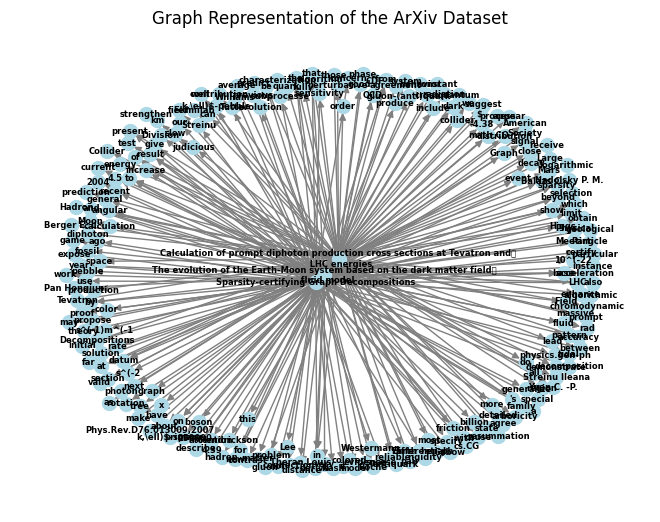

In [42]:
# Erstelle einen leeren gerichteten Graphen
G = nx.DiGraph()

# Füge Knoten (Autoren) und Kanten (Verbindungen) zum Graphen hinzu
for paper_id, author_id in zip(list_of_titles, list_of_authors):
    G.add_node(author_id)
    G.add_edge(paper_id, author_id, weight=0.2)

for paper_id, category in zip(list_of_paper_cat, list_of_categories):
    G.add_node(category)
    G.add_edge(paper_id, category, weight=1)

for paper_id, journal in zip(list_of_paper_journal, list_of_journals):
    G.add_node(journal)
    G.add_edge(paper_id, journal)

for paper_id, word in zip(list_of_paper_word, list_of_words):
    G.add_node(word)
    G.add_edge(paper_id, word)

for paper_id, word_in_title in zip(list_of_paper_titleword, list_of_titlewords):
    G.add_node(word_in_title)
    G.add_edge(paper_id, word_in_title)

# Zeige den Graphen an, deaktiviere die Verarbeitung von LaTeX-Symbolen
plt.rcParams['text.usetex'] = False

pos = nx.spring_layout(G)  # Layout des Graphen
nx.draw(G, pos, with_labels=True, font_size=6, node_size=100, node_color='lightblue', font_color='black', font_weight='bold', edge_color='gray')
plt.title("Graph Representation of the ArXiv Dataset")
plt.show()

In [43]:
edge_index_list_in_journal

[[0], [1]]

### Assign weights

#### tf-idf

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import math

# TF-IDF Vektorizer
vectorizer = TfidfVectorizer()
corpus = [" ".join(words) for words in filtered_all_words]
tfidf_matrix = vectorizer.fit_transform(corpus)

feature_names = vectorizer.get_feature_names_out()

edge_index_list_has_word = []
list_of_paper_word = []
list_of_words = []
tfidf_weights = []

for i in range(len(df_short)):
    paper_title = df_short['title'][i]
    words = filtered_all_words[i]

    for word in words:
        if word in feature_names:  # Prüfen, ob das Wort im Vektorizer vorhanden ist, Bindewörter nicht mehr drinnen
            word_index = feature_names.tolist().index(word)
            print(word)
            print(word_index)
            tfidf_weight = tfidf_matrix[i, word_index]
            print(tfidf_weight)
            list_of_paper_word.append(paper_title)
            list_of_words.append(word)
            tfidf_weights.append(tfidf_weight)


# Zuweisung der Kanten und Gewichte
edge_index_list_has_word.append(list_of_words)
data['paper', 'has_word', 'word'].edge_index = edge_index_list_has_word
data['paper', 'has_word', 'word'].edge_attr = torch.tensor(tfidf_weights, dtype=torch.float)

fully
71
0.08542055472722063
differential
51
0.08542055472722063
calculation
27
0.17084110945444125
perturbative
114
0.17084110945444125
quantum
130
0.08542055472722063
chromodynamic
32
0.08542055472722063
present
120
0.06496453362356344
production
126
0.08542055472722063
massive
98
0.08542055472722063
photon
116
0.08542055472722063
pair
109
0.25626166418166185
hadron
81
0.17084110945444125
collider
34
0.17084110945444125
next
106
0.25626166418166185
lead
91
0.17084110945444125
order
108
0.17084110945444125
perturbative
114
0.17084110945444125
contribution
41
0.08542055472722063
quark
131
0.17084110945444125
antiquark
17
0.08542055472722063
gluon
78
0.3416822189088825
gluon
78
0.3416822189088825
subprocesse
159
0.08542055472722063
include
84
0.08542055472722063
well
170
0.06496453362356344
order
108
0.17084110945444125
resummation
140
0.08542055472722063
initial
86
0.08542055472722063
state
156
0.08542055472722063
gluon
78
0.3416822189088825
radiation
133
0.08542055472722063
valid
169


#### PMI

In [45]:
# Zählung der Wortvorkommen und Paarvorkommen
word_counts = Counter()
pair_counts = Counter()
total_pairs = 0

for words in filtered_all_words:
    unique_words = set(words)
    for word in unique_words:
        word_counts[word] += 1
    for word1 in unique_words:
        for word2 in unique_words:
            if word1 != word2:
                pair_counts[(word1, word2)] += 1

# Anzahl der Gesamtpaare aktualisieren
total_pairs = sum(pair_counts.values())

# Berechnung der PMI-Werte
pmi_values = {}
n_documents = len(filtered_all_words)  # Gesamtzahl der Dokumente
for (word1, word2), count in pair_counts.items():
    prob_word1 = word_counts[word1] / n_documents
    prob_word2 = word_counts[word2] / n_documents
    prob_pair = count / total_pairs
    pmi = math.log(prob_pair / (prob_word1 * prob_word2))
    pmi_values[(word1, word2)] = pmi

# Zuweisung der PMI-Kanten und Gewichte
edge_index_list_has_pmi = [[], []]
pmi_weights = []

for (word1, word2), pmi in pmi_values.items():
    edge_index_list_has_pmi[0].append(word1)
    edge_index_list_has_pmi[1].append(word2)
    pmi_weights.append(pmi)

# Konvertieren der Daten für PyTorch
# data = {}  # Ersetzen oder definieren Sie Ihr 'data'-Objekt entsprechend
data['word', 'co_occurs_with', 'word'].edge_index = edge_index_list_has_pmi
data['word', 'co_occurs_with', 'word'].edge_attr = torch.tensor(pmi_weights, dtype=torch.float)

#### Check results

In [46]:
pair_counts

Counter({('well', 'datum'): 2,
         ('datum', 'well'): 2,
         ('obtain', 'present'): 2,
         ('present', 'obtain'): 2,
         ('year', 'describe'): 2,
         ('year', 'result'): 2,
         ('year', 'also'): 2,
         ('describe', 'year'): 2,
         ('describe', 'result'): 2,
         ('describe', 'also'): 2,
         ('result', 'year'): 2,
         ('result', 'describe'): 2,
         ('result', 'also'): 2,
         ('also', 'year'): 2,
         ('also', 'describe'): 2,
         ('also', 'result'): 2,
         ('well', 'gluon-(anti)quark'): 1,
         ('well', 'judicious'): 1,
         ('well', 'selection'): 1,
         ('well', 'agreement'): 1,
         ('well', 'specify'): 1,
         ('well', 'detailed'): 1,
         ('well', 'order'): 1,
         ('well', 'Fermilab'): 1,
         ('well', 'decay'): 1,
         ('well', 'phase'): 1,
         ('well', 'Hadron'): 1,
         ('well', 'subprocesse'): 1,
         ('well', 'include'): 1,
         ('well', 'distribut

In [47]:
df_pmi = pd.DataFrame({
    'weights': pmi_weights,
})
df_pmi.nsmallest(50, "weights")

,weights
32,-8.597769
59,-8.597769
984,-8.597769
1011,-8.597769
2244,-8.597769
2258,-8.597769
4080,-8.597769
4094,-8.597769
4993,-8.597769
5017,-8.597769


<Axes: >

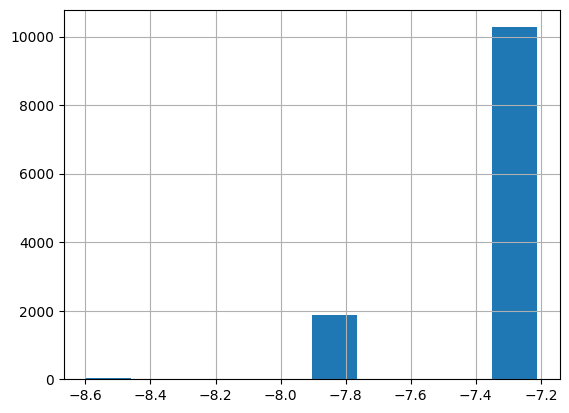

In [48]:
df_pmi.weights.hist()

In [49]:
len(edge_index_list_has_word[0])

200

In [50]:
node_types, edge_types = data.metadata()

In [51]:
print(node_types)
print(edge_types)

['paper', 'author', 'category', 'journal', 'word']
[('paper', 'written_by', 'author'), ('paper', 'has_category', 'category'), ('paper', 'has_word', 'word'), ('paper', 'has_titleword', 'word'), ('paper', 'in_journal', 'journal-ref'), ('word', 'co_occurs_with', 'word')]


In [52]:
import numpy as np

In [53]:
einzigartige_werte = []
for element in edge_index_list_has_word[0]:
    if element not in einzigartige_werte:
        einzigartige_werte.append(element)

len(einzigartige_werte)

144

In [54]:
data.edge_attrs

<bound method BaseData.edge_attrs of HeteroData(
  paper={
    num_nodes=3,
    license=[3],
    doi=[3],
    title=[3],
    pages=[3],
    journal=[3],
    date=[3],
    id=[3],
  },
  author={
    num_nodes=7,
    name=[7],
  },
  category={
    num_nodes=4,
    name=[4],
  },
  journal={
    num_nodes=3,
    name=[3],
  },
  word={
    num_nodes=184,
    name=[184],
  },
  (paper, written_by, author)={ edge_index=[2, 7] },
  (paper, has_category, category)={ edge_index=[2, 4] },
  (paper, has_word, word)={
    edge_index=[1],
    edge_attr=[200],
  },
  (paper, has_titleword, word)={ edge_index=[2, 31] },
  (paper, in_journal, journal-ref)={ edge_index=[2, 1] },
  (word, co_occurs_with, word)={
    edge_index=[2],
    edge_attr=[12178],
  }
)>

In [55]:
# Kanten Paper without weights

# edge_index_list_has_word = []
# list_of_paper_word = []
# list_of_words = []

# # Iteriere durch die Zeilen des DataFrames
# for i in range(len(df_short)):
#     # Holen der ID des Papers aus der aktuellen Zeile
#     paper_title = df_short['title'][i]
    
#     # Holen der Wortinformationen aus der aktuellen Zeile
#     words = all_words[i]
    
#     # Hier gehe ich davon aus, dass die Wörter als Liste vorliegen
#     for word in words:
#         list_of_words.append(word)
#         list_of_paper_word.append(paper_title)

# edge_index_list_has_word.append(list_of_paper_word)
# edge_index_list_has_word.append(list_of_words)

# # Weise die Edge-Indizes dem HeteroData-Objekt zu
# data['paper', 'has_word', 'word'].edge_index = edge_index_list_has_word

In [56]:
data.edge_attrs

<bound method BaseData.edge_attrs of HeteroData(
  paper={
    num_nodes=3,
    license=[3],
    doi=[3],
    title=[3],
    pages=[3],
    journal=[3],
    date=[3],
    id=[3],
  },
  author={
    num_nodes=7,
    name=[7],
  },
  category={
    num_nodes=4,
    name=[4],
  },
  journal={
    num_nodes=3,
    name=[3],
  },
  word={
    num_nodes=184,
    name=[184],
  },
  (paper, written_by, author)={ edge_index=[2, 7] },
  (paper, has_category, category)={ edge_index=[2, 4] },
  (paper, has_word, word)={
    edge_index=[1],
    edge_attr=[200],
  },
  (paper, has_titleword, word)={ edge_index=[2, 31] },
  (paper, in_journal, journal-ref)={ edge_index=[2, 1] },
  (word, co_occurs_with, word)={
    edge_index=[2],
    edge_attr=[12178],
  }
)>

# Visualization

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from collections import Counter
from math import log
import torch
import networkx as nx
import matplotlib.pyplot as plt

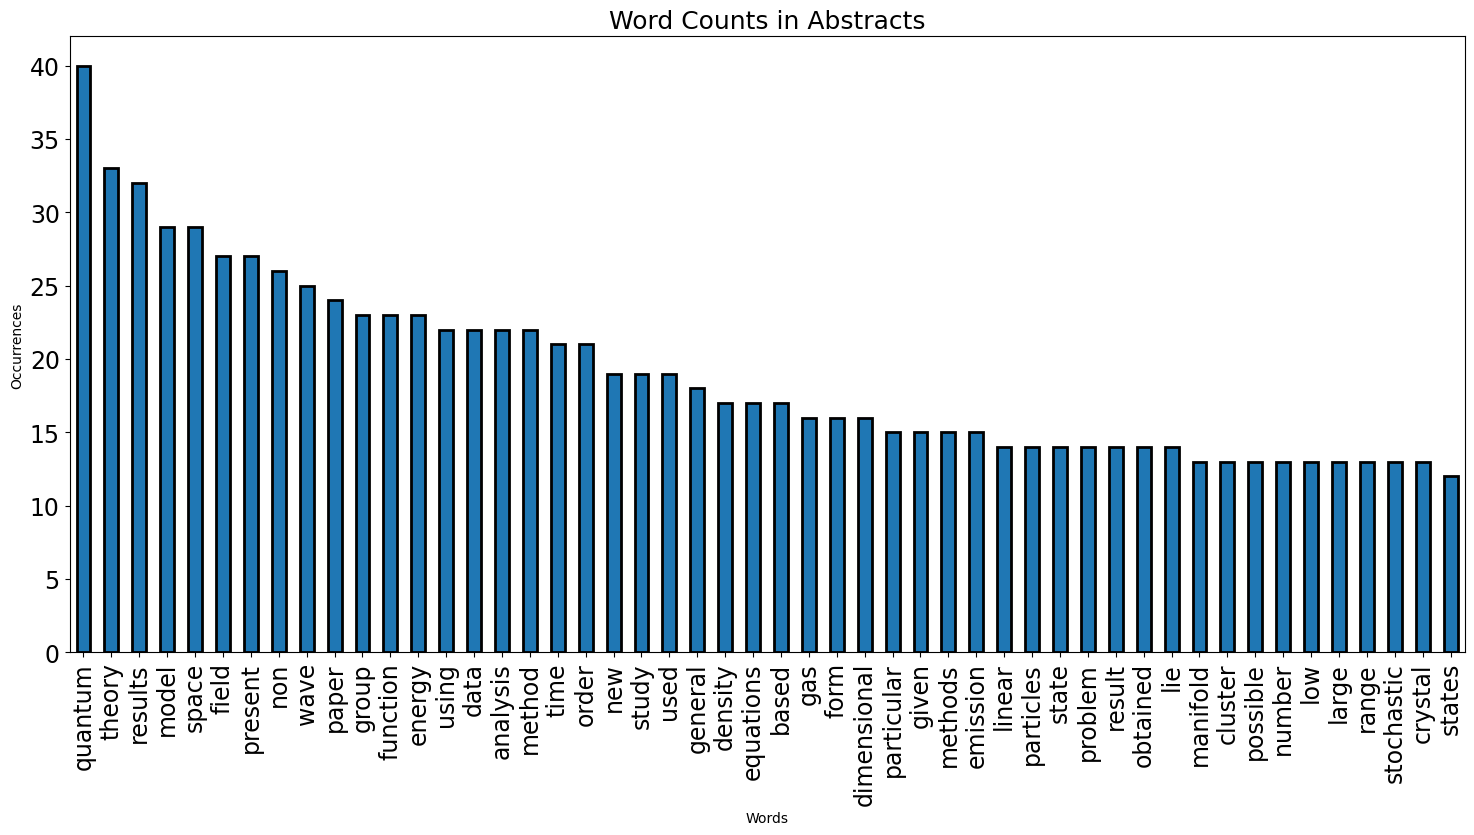

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

# Ihr DataFrame und die Spalte 'abstract'
abstracts = df[:100]['abstract'].tolist()

counter = CountVectorizer(stop_words='english')
count_matrix = counter.fit_transform(abstracts)

# Verwenden Sie die entsprechende Methode je nach Ihrer scikit-learn Version
try:
    features = counter.get_feature_names_out()
except AttributeError:
    features = counter.get_feature_names()

abstracts_counter = pd.Series(count_matrix.toarray().sum(axis=0), 
                              index=features).sort_values(ascending=False)

bar_graph = abstracts_counter[:50].plot(kind='bar', figsize=(18,8), alpha=1, fontsize=17, rot=90, edgecolor='black', linewidth=2,
            title='Word Counts in Abstracts')
bar_graph.set_xlabel('Words')
bar_graph.set_ylabel('Occurrences')
bar_graph.title.set_size(18)
plt.show()


doc_id: 0, word_id: energies, weight: 0.3333333333333333
doc_id: 0, word_id: lhc, weight: 0.3333333333333333
doc_id: 0, word_id: tevatron, weight: 0.3333333333333333
doc_id: 0, word_id: sections, weight: 0.3333333333333333
doc_id: 0, word_id: cross, weight: 0.3333333333333333
doc_id: 0, word_id: production, weight: 0.3333333333333333
doc_id: 0, word_id: diphoton, weight: 0.3333333333333333
doc_id: 0, word_id: prompt, weight: 0.3333333333333333
doc_id: 0, word_id: calculation, weight: 0.3333333333333333


C:\Users\Ilgar\AppData\Local\Temp\ipykernel_18440\1328852984.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  pmi = math.log((count_word1_word2 * total_count) / (count_word1 * count_word2), 2)


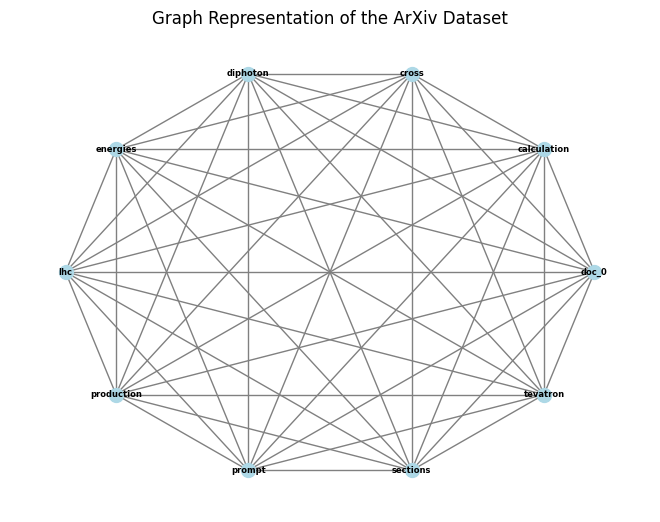

In [59]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import math
import itertools

# Angenommen, df ist Ihr DataFrame mit einer Spalte 'document' für Dokumente
documents = df['title'][:1].tolist()

# Berechnung der TF-IDF-Werte
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Erstellung des Graphen
G = nx.Graph()

# Hinzufügen von Dokument- und Wortknoten
for doc_id, doc in enumerate(documents):
    G.add_node(f'doc_{doc_id}', type='document')

for word in feature_names:
    G.add_node(word, type='word')

# Hinzufügen von Dokument-Wort-Kanten mit TF-IDF-Gewichtungen
for doc_id in range(tfidf_matrix.shape[0]):
    for word_id in tfidf_matrix[doc_id].nonzero()[1]:
        tfidf_weight = tfidf_matrix[doc_id, word_id]
        G.add_edge(f'doc_{doc_id}', feature_names[word_id], weight=tfidf_weight)
        print(f"doc_id: {doc_id}, word_id: {feature_names[word_id]}, weight: {tfidf_weight}")
        
# Berechnung der PMI-Werte für Wort-Wort-Kanten
word_counts = Counter(np.array(tfidf_matrix.sum(axis=0)).flatten())
total_count = sum(word_counts.values())
word_pairs = itertools.combinations(feature_names, 2)

for word1, word2 in word_pairs:
    count_word1 = word_counts[word1]
    count_word2 = word_counts[word2]
    count_word1_word2 = (tfidf_matrix[:, feature_names.tolist().index(word1)] 
                         + tfidf_matrix[:, feature_names.tolist().index(word2)]).sum()
    pmi = math.log((count_word1_word2 * total_count) / (count_word1 * count_word2), 2)
    if pmi > 0:
        G.add_edge(word1, word2, weight=pmi)

# Zeige den Graphen an, deaktiviere die Verarbeitung von LaTeX-Symbolen
plt.rcParams['text.usetex'] = False

# circular_layout sonst Zahl zu groß für Visualisierung von pmi, davor spring genommen
pos = nx.circular_layout(G)  # Layout des Graphen
nx.draw(G, pos, with_labels=True, font_size=6, node_size=100, node_color='lightblue', font_color='black', font_weight='bold', edge_color='gray')

# # Gewichte der Kanten holen
# edge_weights = nx.get_edge_attributes(G, 'weight')
# # Kanten-Labels zeichnen
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_size=5)

plt.title("Graph Representation of the ArXiv Dataset")
plt.show()